#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
# diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [20]:
E = 210e9

In [21]:
E*Ar/1e10

1.6991625880187402

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 5.83448816e-01, -7.64695800e-01, -2.73546728e-01],
       [-2.56844386e-04, -3.36991743e-01,  9.41507567e-01],
       [-8.12149871e-01, -5.49251217e-01, -1.96813841e-01]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.011738


In [35]:
Ret.shape

(50, 3, 3)

In [36]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [37]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [38]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000317


In [39]:
C1(dx,dy,dz,Ret)

array([[-1.94380036e-01, -9.84023610e-01, -2.28748700e+00,
         2.40234216e-01, -3.71441328e-01, -1.14711064e+00,
         1.82758844e+00, -8.61609706e-01, -1.80460727e-02,
         8.77510519e+00, -6.02377785e+00, -1.14914008e+00,
         1.35769055e-01,  3.82925668e-01,  1.96673994e+00,
         4.85677113e+00, -9.08383399e-01,  1.14459815e+00,
         2.16298858e-01,  2.64191231e-01, -2.63386363e-01,
        -1.69092253e+00,  3.74188736e-01,  7.77363261e-01,
        -1.74927545e-02,  3.20247507e+00, -1.06529257e-01,
        -2.19932676e-01,  1.52894174e+00, -1.75377787e-01,
        -1.40278863e-01, -2.78961211e+00,  4.63997616e+00,
        -1.12367257e+00, -1.24630723e-01, -5.34034124e-01,
         3.98499380e-01, -7.38801992e-01,  1.47998399e+00,
         3.92338546e-01,  8.54985929e-01, -1.14222592e+00,
         6.43446903e-01,  1.40719994e+00,  2.22345389e-01,
        -7.18649905e-01,  6.43790146e-01, -2.06885183e+00,
         4.93634671e-03,  7.71172682e-02],
       [ 3.81

In [40]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [41]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.11555363e+03,  2.18759438e+03,  3.88351526e+03],
       [-5.64734490e+03, -1.98159778e+03,  1.48917793e+03],
       [-1.31279655e+04,  4.16006064e+03, -1.51663307e+02],
       [ 1.37871232e+03,  4.95546099e+03,  3.33266488e+03],
       [-2.13171439e+03, -7.19798370e+03,  7.00063727e+03],
       [-6.58330692e+03,  2.48741379e+04, -2.37630375e+04],
       [ 1.04885921e+04, -3.26106313e+01,  1.12454476e+03],
       [-4.94480735e+03, -6.28694628e+02,  2.06193848e+03],
       [-1.03567024e+02,  4.01377937e+03, -3.33957173e+02],
       [ 5.03606265e+04,  5.80768071e+02, -7.66711873e+03],
       [-3.45706655e+04,  3.19640532e+01,  9.14916475e+03],
       [-6.59495394e+03,  4.63667913e+03, -9.82081603e+02],
       [ 7.79183216e+02,  1.25309868e+04,  1.39024373e+01],
       [ 2.19762340e+03,  1.65074286e+04,  1.22254733e+04],
       [ 1.12871873e+04,  1.93518292e+04, -6.58465500e+03],
       [ 2.78731743e+04, -7.50391821e+02, -2.34556465e+02],
       [-5.21324316e+03, -9.42321173e+02

In [42]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001482


In [43]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000297


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
Ar

0.08091250419136858

In [51]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [52]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [53]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [54]:
def Re_b(Ret):
    return Ret

In [55]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000139


In [56]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [57]:
phi(x,y,z,Ret,None,None)

array([[ 0.74797573, -0.06462811,  0.80409755],
       [-0.4289176 ,  1.17825635, -2.38186468],
       [ 0.60095434, -0.85740739,  0.53073238],
       [-0.37698635,  1.98287659, -1.13879945],
       [ 0.43352728, -0.09629277,  1.51634066],
       [ 1.34639115, -1.701487  , -1.29611253],
       [-0.99614278,  1.76027738, -1.0376613 ],
       [ 2.24052312, -0.50074731, -1.53064041],
       [ 1.71579229, -1.80296218, -1.30647286],
       [ 0.39325356,  1.13708444,  1.69727334],
       [ 0.14303647, -0.87288267, -1.99394525],
       [ 0.68209435, -0.81827849, -0.29347925],
       [ 1.2018848 ,  0.28083343, -1.30199308],
       [-0.25701426,  1.20888146,  1.09010885],
       [-1.3639493 ,  0.49442424,  0.74072563],
       [-0.31192362,  0.38966803,  0.67795206],
       [ 0.40760676,  0.7454042 ,  0.57582465],
       [ 2.05350724,  0.86171449,  0.30379892],
       [-0.85910726,  0.16085103,  1.24053149],
       [ 0.13850786,  0.20816223, -0.48354886],
       [-1.5498114 , -1.76830408,  0.078

In [58]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000317


In [59]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [60]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [61]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001467


In [62]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [63]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.005347


In [64]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.42404206,  2.69095259,  0.39558216],
       [-1.11834629,  0.94782753,  1.55392229],
       [-0.24781211, -0.42609654,  1.17939518],
       [ 0.50625053,  0.32949701,  0.29605966],
       [-0.42605586, -0.96717428, -0.31853737],
       [-0.32049679,  0.75565632,  0.99782483],
       [ 0.43181033,  2.20256736,  0.97188751],
       [ 0.7878977 , -1.4465818 ,  1.16430425],
       [-0.21319626, -1.04599022, -0.68530742],
       [ 0.10939495,  1.73062926, -0.55229502],
       [-1.68022523,  0.0097736 ,  0.69041058],
       [ 0.13462029, -1.60208951,  1.64174286],
       [-1.28580395, -1.07728942, -1.30534624],
       [-0.20126265, -0.58530433, -0.19579452],
       [-0.27568126, -1.75508613,  1.1378049 ],
       [-0.09552335, -1.70641177, -1.27546297],
       [-0.09763431, -0.51028726, -0.15401696],
       [ 0.79774905,  0.19741936,  0.13735801],
       [-0.87543746, -0.68001954,  0.69618404],
       [ 0.28544916,  1.68177984, -1.10773516],
       [-0.26403939,  1.75233654, -1.386

In [65]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [66]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [67]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 8.68716978e-06, -3.56008543e-05,  1.38812589e-05,
        -3.12164482e-05,  1.61261730e-05,  4.05370414e-06,
        -2.79791070e-05, -1.02988280e-05,  4.96484352e-06,
         5.60183299e-06, -1.12105137e-05,  5.24793994e-06,
        -1.58281069e-05, -1.18771425e-06,  2.46298927e-06,
         2.88281149e-06, -1.69577853e-06, -5.57909988e-06,
         1.07966966e-05, -6.91704175e-06,  1.84713966e-05,
        -5.82669037e-06, -4.76117197e-06,  4.35700132e-07,
         1.35607056e-06,  7.05415089e-06, -2.09779754e-06,
         7.22080520e-06, -9.44080967e-06,  1.34352440e-05,
         1.48574263e-06, -2.25149707e-05,  2.95581839e-05,
        -4.85712864e-06, -1.16165251e-05,  2.08695825e-05,
        -2.00383695e-05,  1.67727420e-06,  1.86544690e-06,
         4.67613121e-06,  3.80109603e-06, -1.75778460e-05,
        -2.01336698e-05, -3.30583666e-06, -1.30957500e-05,
         1.35261728e-05,  1.75068642e-05, -3.20544640e-06,
         6.13827592e-06,  1.30023512e-05],
       [-5.61

In [68]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.004982


In [69]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [70]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [71]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [72]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [73]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-3.32944739e-07,  2.18678400e-06,  8.01077604e-07,
        -4.56246478e-07, -4.87260280e-07, -2.22741557e-07,
        -8.90649240e-07, -1.01449241e-06,  2.39916289e-06,
        -1.11111234e-06,  2.20686327e-06,  3.59510071e-07,
         2.71005798e-06, -1.14941909e-06, -2.74423509e-07,
        -1.13621710e-06, -3.71842443e-07, -2.52640184e-06,
        -5.29857387e-07, -7.19804402e-07, -1.71009735e-06,
        -9.07078573e-08, -9.52012089e-07, -3.65972594e-07,
         1.50344384e-06, -1.51338474e-07, -1.58683971e-06,
         4.47803510e-07, -4.96817234e-07, -2.72158017e-07,
        -3.82173331e-07, -7.45501759e-07,  3.80411820e-06,
        -2.40470746e-06,  6.62649699e-07, -1.06375410e-06,
         3.30802813e-07, -2.45821809e-06,  6.51953659e-07,
         1.98135842e-06,  9.51362009e-08, -7.72236614e-07,
         4.70865136e-06, -7.04597747e-07,  2.69523273e-06,
         3.54790356e-07, -7.10493809e-07, -2.94598839e-06,
         1.67539854e-07, -1.76226705e-06],
       [-9.46

In [74]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [75]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.11555363e+03,  5.64734490e+03,  1.31279655e+04,
        -1.37871232e+03,  2.13171439e+03,  6.58330692e+03,
        -1.04885921e+04,  4.94480735e+03,  1.03567024e+02,
        -5.03606265e+04,  3.45706655e+04,  6.59495394e+03,
        -7.79183216e+02, -2.19762340e+03, -1.12871873e+04,
        -2.78731743e+04,  5.21324316e+03, -6.56888761e+03,
        -1.24134649e+03, -1.51620244e+03,  1.51158328e+03,
         9.70426179e+03, -2.14748186e+03, -4.46131414e+03,
         1.00391512e+02, -1.83791131e+04,  6.11375021e+02,
         1.26220109e+03, -8.77464852e+03,  1.00649907e+03,
         8.05065153e+02,  1.60096786e+04, -2.66289807e+04,
         6.44879499e+03,  7.15259950e+02,  3.06483996e+03,
        -2.28700146e+03,  4.24000970e+03, -8.49367833e+03,
        -2.25164423e+03, -4.90679326e+03,  6.55527332e+03,
        -3.69276361e+03, -8.07596821e+03, -1.27604773e+03,
         4.12435619e+03, -3.69473349e+03,  1.18732109e+04,
        -2.83298613e+01, -4.42578619e+02],
       [-2.18

In [76]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004383


In [77]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 1.77936527e+02,  1.28071721e+04, -1.29851090e+04],
       [ 5.34307025e+02, -3.91125075e+03,  3.37694266e+03],
       [-1.09766565e+03,  2.56157789e+03, -1.46391004e+03],
       [ 8.79444334e+03, -1.32093722e+04,  4.41491131e+03],
       [ 5.04383427e+02, -5.77592411e+02,  7.32079761e+01],
       [ 8.82126494e+03, -7.48094676e+03, -1.34033583e+03],
       [ 1.10127437e+03,  3.17756827e+03, -4.27884484e+03],
       [-1.46164234e+02,  1.45290229e+02,  8.74296738e-01],
       [-7.20051601e+03,  2.56097752e+03,  4.63955289e+03],
       [ 4.32211676e+03, -1.07725326e+03, -3.24487214e+03],
       [ 7.94689627e+01, -1.68366017e+04,  1.67571326e+04],
       [-1.39252318e+00,  1.10385631e+00,  2.88669651e-01],
       [-3.82823988e+02, -1.34034893e+03,  1.72317368e+03],
       [-7.04539250e+03, -3.63729611e+03,  1.06827027e+04],
       [-2.68873013e+02,  2.82459086e+02, -1.35855358e+01],
       [-1.36247924e+02,  6.97883605e+01,  6.64598358e+01],
       [-7.69784680e+03, -4.92416614e+03

In [78]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 1.29652427e+10, -1.98792461e+07,  1.58057458e+08],
       [-3.37644641e+09,  4.99628544e+05,  5.34807188e+08],
       [-5.09887469e+08, -1.97379503e+09, -3.07146177e+09],
       [-9.93076896e+09, -5.51584221e+09,  3.27860993e+09],
       [-2.90021730e+09, -2.82700360e+09, -2.32261967e+09],
       [-1.00674878e+09, -2.34708125e+09,  6.47419252e+09],
       [ 3.17767414e+09, -1.10117278e+09,  1.02692544e+05],
       [-3.09136298e+07, -3.00392721e+07, -1.76203652e+08],
       [-1.75450423e+09,  2.88504752e+09, -4.31547568e+09],
       [ 5.73170821e+07, -3.18755193e+09,  1.13456915e+09],
       [-1.68287267e+10, -7.15772820e+07,  7.89176013e+06],
       [ 5.20775933e+05,  8.09444254e+05, -5.83080315e+05],
       [-1.79204555e+09, -6.88700088e+07, -4.51694380e+08],
       [-9.79821142e+09,  8.84500194e+08, -6.16089935e+09],
       [ 1.04353805e+08,  9.07680739e+07, -1.78105207e+08],
       [ 4.21682171e+07,  1.08627902e+08, -2.76201580e+07],
       [-1.11611217e+10,  1.46091637e+09

In [79]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000284


In [80]:
Re_b(Ret).shape

(50, 3, 3)

In [81]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [82]:
Irho_e(Ret)

array([[[4.17372869e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.77510879e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.31229559e-04]],

       [[1.70206261e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.67817174e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.87356881e-04]],

       [[4.82675116e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.24718516e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.04102941e-03]],

       [[3.49401604e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.40483513e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.08141047e-03]],

       [[1.53800799e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.67681622e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.70612876e-03]],

       [[7.59658552e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.25383246e-04, 0.00000000e+00],
    

In [83]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000110


In [84]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [85]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [86]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [87]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [88]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.007667


In [89]:
d_me_

array([[-3.33914468e-15, -3.62559448e-12,  4.28825236e-12],
       [-1.36171604e-15, -2.10603775e-11,  7.18370119e-12],
       [-3.86158796e-16, -2.31708521e-11,  1.67669808e-10],
       [-2.79534822e-15, -1.26285566e-10,  1.31327825e-10],
       [-1.23046599e-15, -1.36373363e-10,  3.16408971e-11],
       [-6.07756277e-16, -3.43225273e-11,  1.30797473e-10],
       [-1.30774400e-15, -3.04389179e-11,  1.55753866e-15],
       [-5.95953859e-17, -3.79601472e-12,  1.94406268e-12],
       [-8.80139811e-16, -1.00871950e-10,  5.69799431e-11],
       [-8.99435543e-17, -1.30643359e-10,  1.29985046e-11],
       [-3.97327775e-15, -9.57686272e-12,  9.57993352e-12],
       [-3.91631389e-18, -1.06871579e-12,  6.36419275e-15],
       [-8.92647798e-16, -1.14895169e-11,  5.60612269e-12],
       [-2.77042400e-15, -1.71180037e-10,  1.21847862e-10],
       [-1.34107649e-16, -2.79712785e-11,  1.97766180e-12],
       [-7.33001092e-17, -1.43620195e-11,  3.05169870e-13],
       [-3.02171558e-15, -1.79326947e-10

In [90]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [91]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.11555363e+03,  5.64734490e+03,  1.31279655e+04,
        -1.37871232e+03,  2.13171439e+03,  6.58330692e+03,
        -1.04885921e+04,  4.94480735e+03,  1.03567024e+02,
        -5.03606265e+04,  3.45706655e+04,  6.59495394e+03,
        -7.79183216e+02, -2.19762340e+03, -1.12871873e+04,
        -2.78731743e+04,  5.21324316e+03, -6.56888761e+03,
        -1.24134649e+03, -1.51620244e+03,  1.51158328e+03,
         9.70426179e+03, -2.14748186e+03, -4.46131414e+03,
         1.00391512e+02, -1.83791131e+04,  6.11375021e+02,
         1.26220109e+03, -8.77464852e+03,  1.00649907e+03,
         8.05065153e+02,  1.60096786e+04, -2.66289807e+04,
         6.44879499e+03,  7.15259950e+02,  3.06483996e+03,
        -2.28700146e+03,  4.24000970e+03, -8.49367833e+03,
        -2.25164423e+03, -4.90679326e+03,  6.55527332e+03,
        -3.69276361e+03, -8.07596821e+03, -1.27604773e+03,
         4.12435619e+03, -3.69473349e+03,  1.18732109e+04,
        -2.83298613e+01, -4.42578619e+02],
       [-2.18

### Static solution

In [92]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [93]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [94]:
Fx_0=82945396

In [95]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [96]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [97]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [98]:
delta_x=horizontal_length/(node_N-1)

In [99]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [100]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [101]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

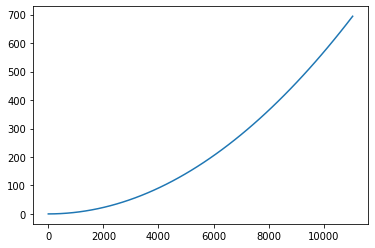

In [102]:
plt.plot(x0, z0)
plt.show()

In [103]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [104]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [105]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [107]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [108]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [109]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [110]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [111]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [112]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [113]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

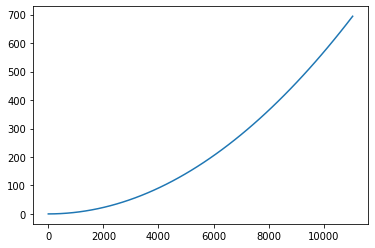

In [114]:
plt.plot(x0_, z0_)
plt.show()

In [158]:
init=1e-3
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.055*i*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.000001*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [159]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [160]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [161]:
vehicle=semisub('DPcontrol',0,-5,40.0,0,0) 

In [162]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [163]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

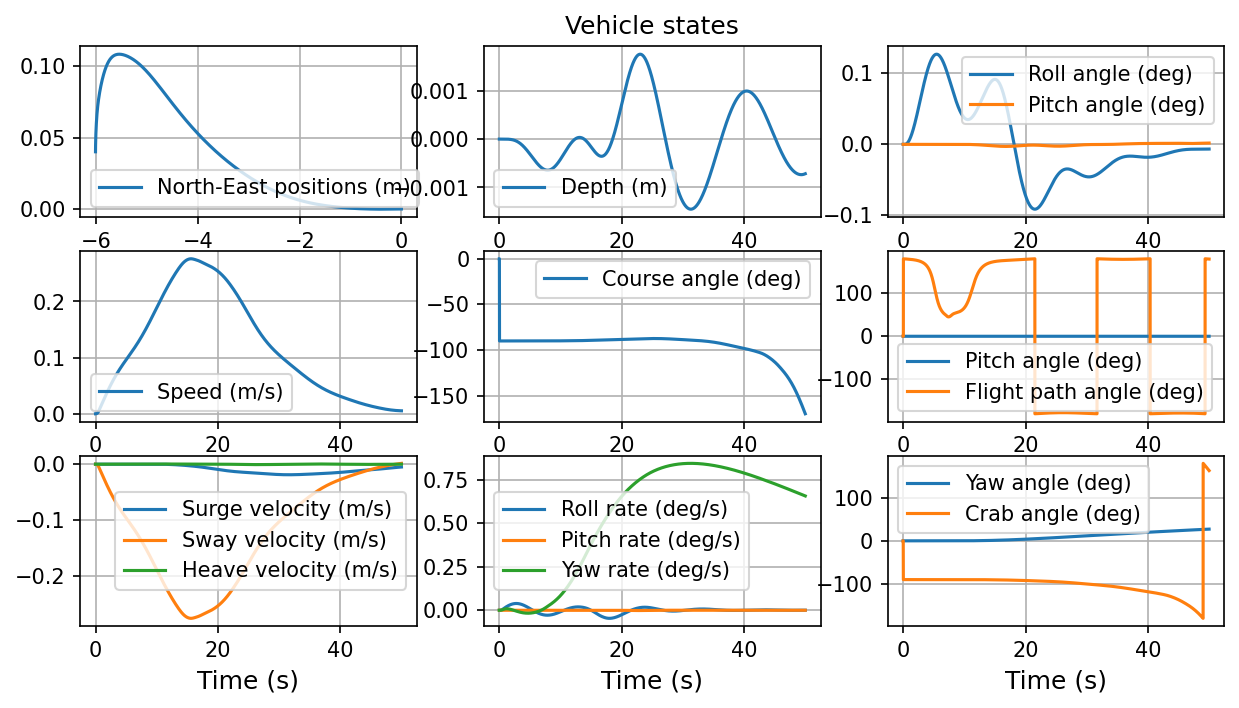

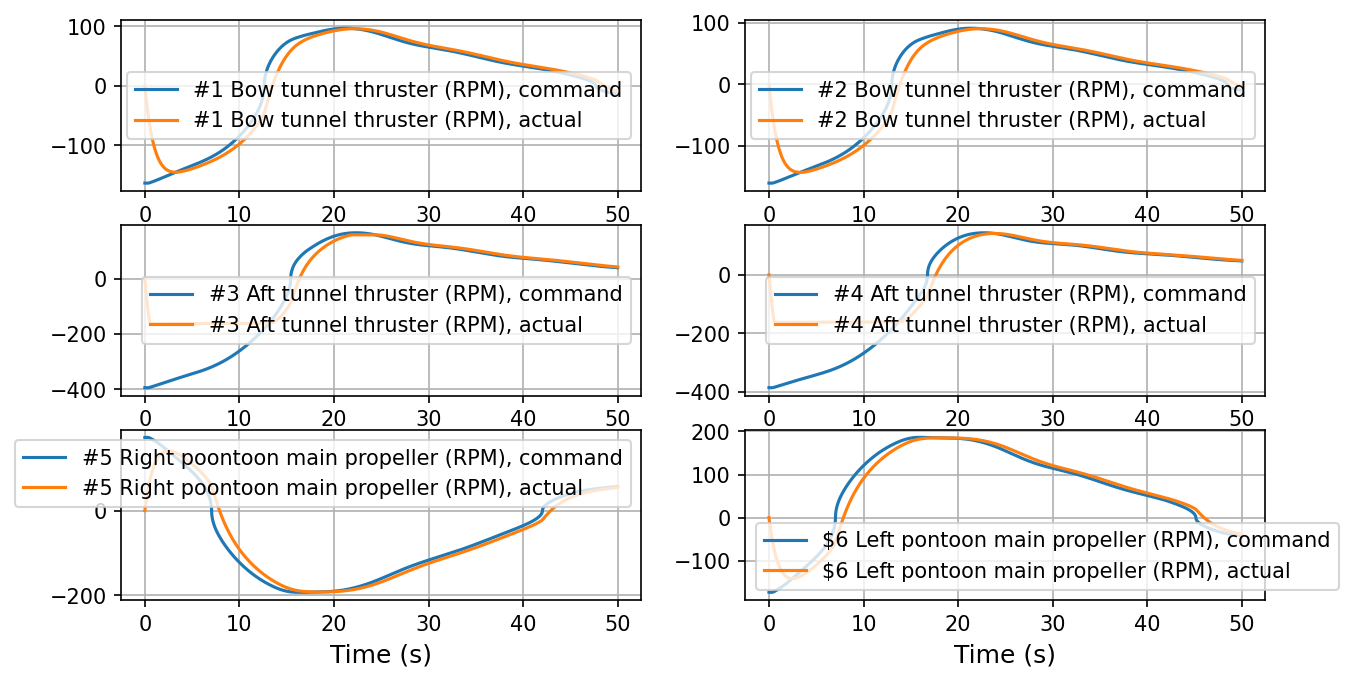

In [164]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [165]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

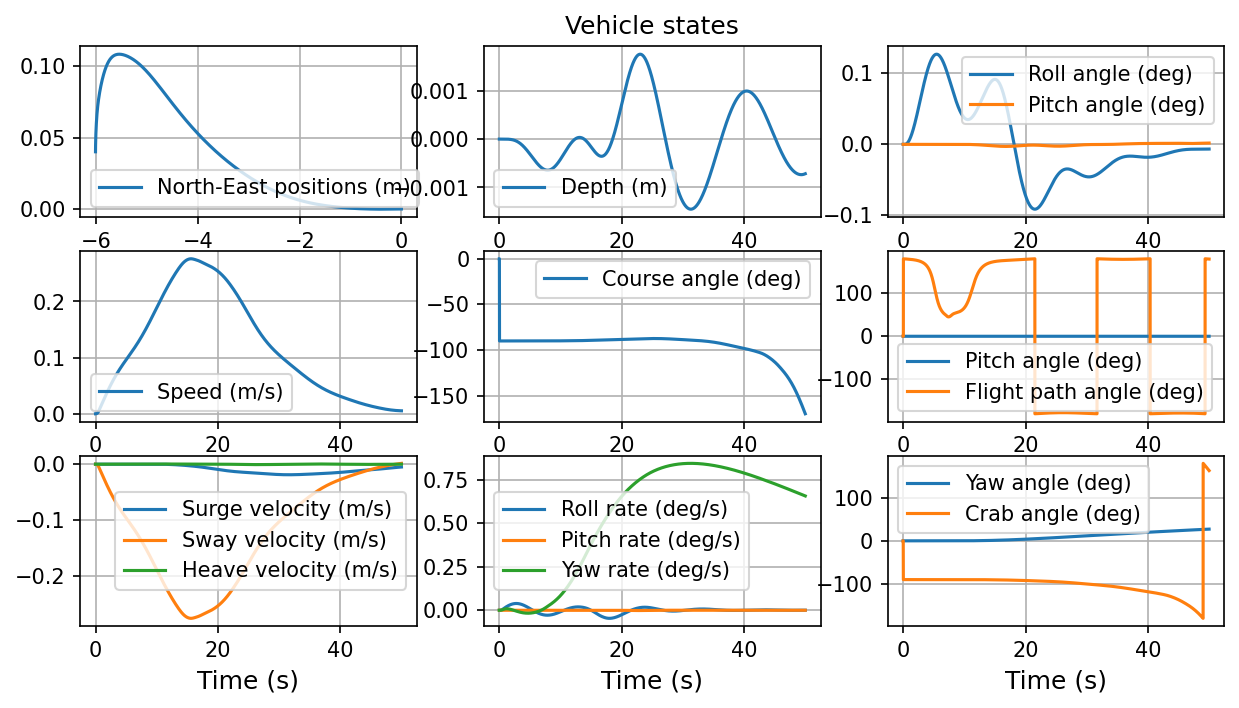

In [166]:
plotVehicleStates(simTime, simData, 3)

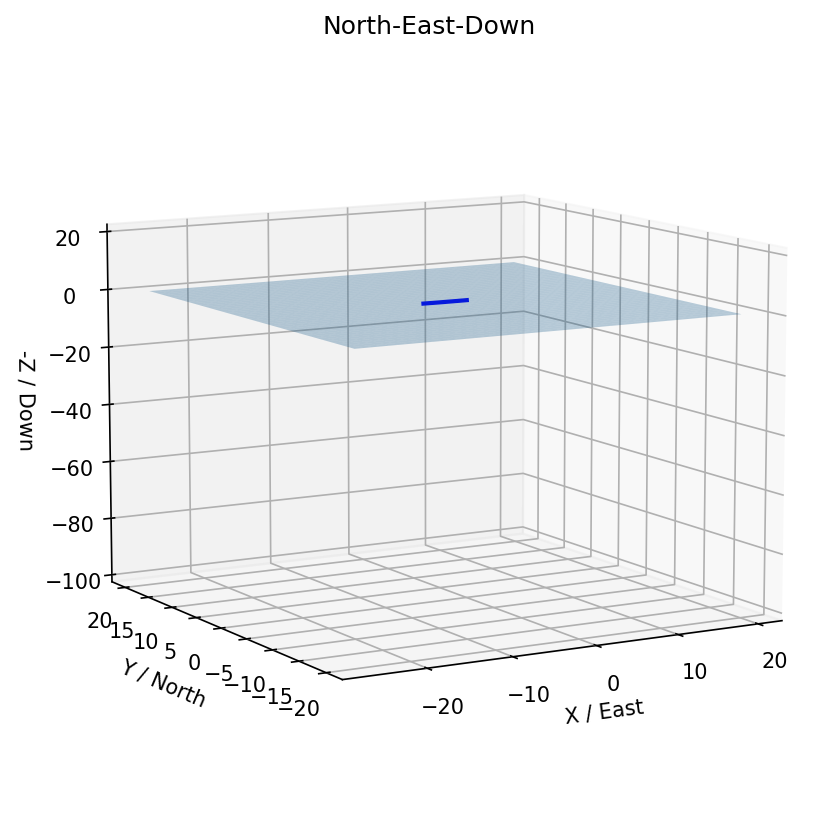

In [167]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [168]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [169]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [170]:
# Ws[0]*Ret[2]

In [171]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [172]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1e-3
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(Ret)
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1e16
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [173]:
# import scipy

In [174]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [175]:
# us=ode15s.integrate(10)

In [176]:
tspan = (0., 5)

In [177]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:19.505033


In [178]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init) and force_schedule 

### Results

In [179]:
fin=us

In [180]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.14650982e-06, 5.00994927e-05, 2.15477936e-04,
       8.21708177e-04, 2.95556708e-03, 1.03807080e-02, 3.63973799e-02,
       5.70943790e-02, 7.77913780e-02, 1.07821888e-01, 1.43986960e-01,
       1.93492723e-01, 2.58762090e-01, 3.09406398e-01, 3.60050706e-01,
       4.18396014e-01, 4.72771777e-01, 5.27147539e-01, 5.84431798e-01,
       6.38923761e-01, 6.88102426e-01, 7.36831069e-01, 7.90256965e-01,
       8.48220075e-01, 9.06400951e-01, 9.59131984e-01, 1.00708415e+00,
       1.05667754e+00, 1.11259639e+00, 1.17259686e+00, 1.22226947e+00,
       1.27194208e+00, 1.33050536e+00, 1.38529063e+00, 1.44007590e+00,
       1.49748716e+00, 1.55367603e+00, 1.60557543e+00, 1.65574579e+00,
       1.70853752e+00, 1.76593800e+00, 1.82471125e+00, 1.87854259e+00,
       1.92794863e+00, 1.97906013e+00, 

In [181]:
t=fin.t

In [182]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


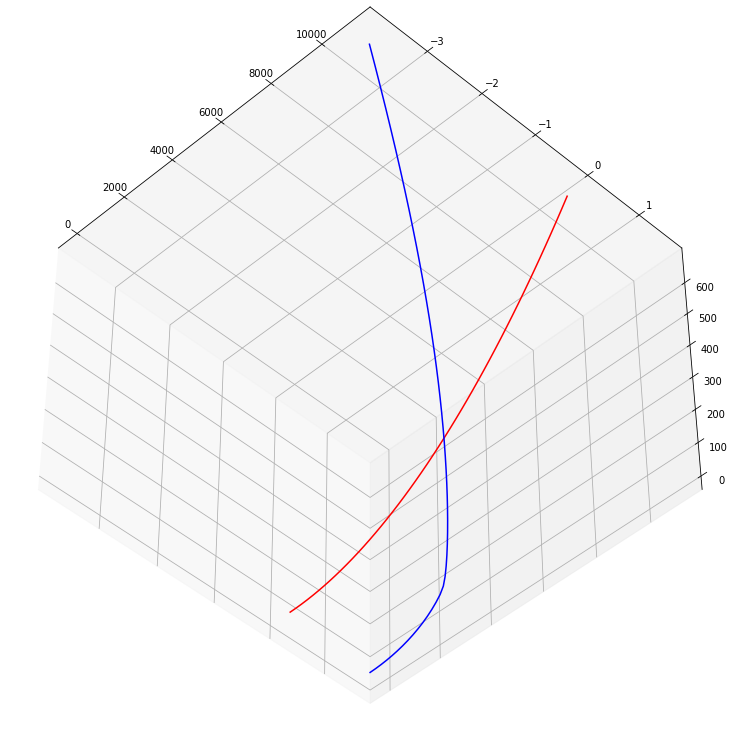

In [202]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [184]:
X,Y,Z

(array([2.96289674e-01, 2.25855618e+02, 4.51412456e+02, 6.76965870e+02,
        9.02514523e+02, 1.12805641e+03, 1.35358933e+03, 1.57911262e+03,
        1.80462671e+03, 2.03013233e+03, 2.25562995e+03, 2.48111968e+03,
        2.70660125e+03, 2.93207409e+03, 3.15753748e+03, 3.38299052e+03,
        3.60843226e+03, 3.83386164e+03, 4.05927753e+03, 4.28467872e+03,
        4.51006393e+03, 4.73543176e+03, 4.96078074e+03, 5.18610930e+03,
        5.41141574e+03, 5.63669826e+03, 5.86195493e+03, 6.08718369e+03,
        6.31238233e+03, 6.53754851e+03, 6.76267972e+03, 6.98777326e+03,
        7.21282629e+03, 7.43783576e+03, 7.66279840e+03, 7.88771076e+03,
        8.11256915e+03, 8.33736963e+03, 8.56210801e+03, 8.78677986e+03,
        9.01138042e+03, 9.23590466e+03, 9.46034722e+03, 9.68470242e+03,
        9.90896421e+03, 1.01331262e+04, 1.03571815e+04, 1.05811230e+04,
        1.08049429e+04, 1.10281273e+04]),
 array([ 1.47321763e+00,  1.47161493e+00,  1.46921868e+00,  1.46588136e+00,
         1.4614494

In [185]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [186]:
us=fin.T

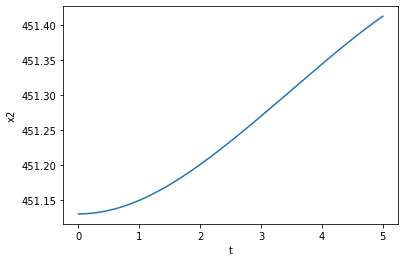

In [187]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

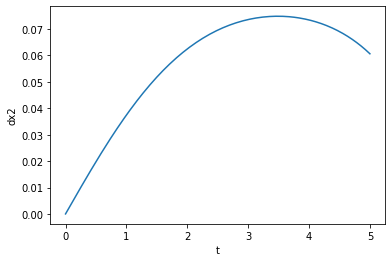

In [188]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

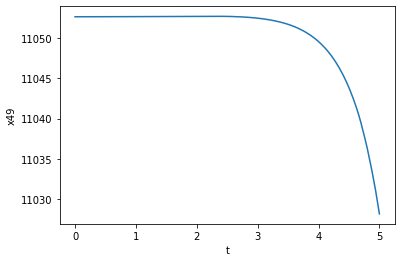

In [189]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

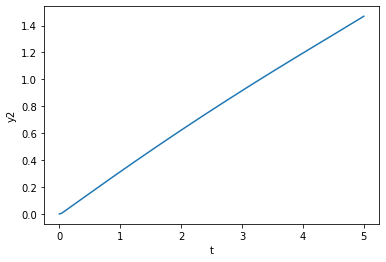

In [190]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

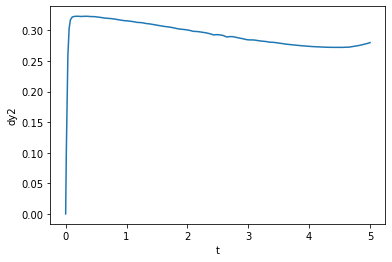

In [191]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

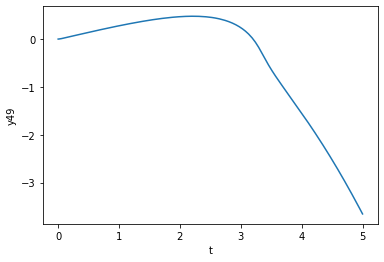

In [192]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

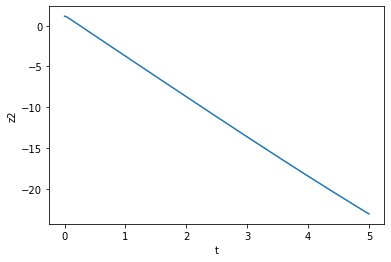

In [193]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

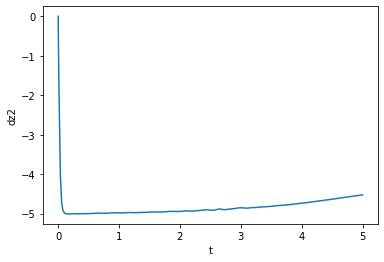

In [194]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

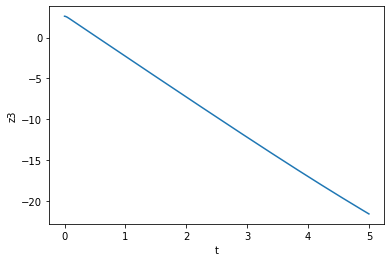

In [195]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

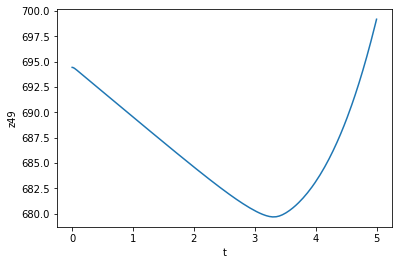

In [196]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

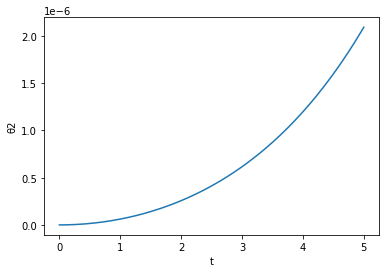

In [197]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

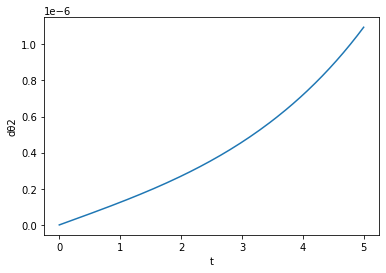

In [198]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

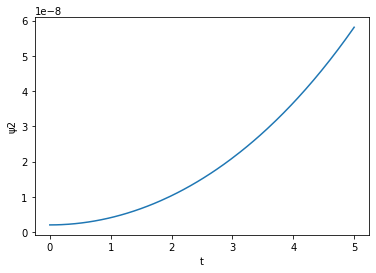

In [199]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

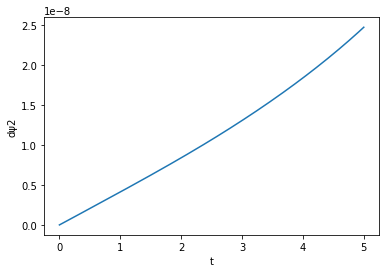

In [200]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()